In [1]:
# Thoomas Goldman 2023
# DOLPHINN
import sys
import os
import matplotlib.pyplot as plt

#Get the absolute path of the current scriptf
current_path = os.path.dirname(os.path.abspath('__file__'))
dolphinn_path = os.path.join(current_path, '..')
sys.path.append(dolphinn_path)

from DOLPHINN.pinn import DOLPHINN 
from DOLPHINN.dynamics import TwoBodyProblemRadialNonDimensionalControl
from DOLPHINN.output_layers import InitialFinalStateLayer_Radial
from DOLPHINN.training import Scheduler, Restarter
from DOLPHINN.objectives import OptimalFuel
import DOLPHINN.plotting as plotting
from DOLPHINN import utils

import numpy as np

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [16]:
mu = 1.32712440042e20 # SUN
m = 100 #Spacecraft mass
AU = 1.5e11 #EARTH-SUN
a = 10
umax = 1
isp = 2500

rp = AU
ra = 1.5*AU

e = (ra - rp)/(ra + rp)
sma = (rp + ra)/2

# Initial state
r0 = AU
vr0 = 0
vt0 = np.sqrt(mu/r0)
initial_state = np.array([r0, vr0, vt0])

# Final state
rfinal = 1.5*AU
vr_final = 0
vt_final = np.sqrt(mu/rfinal)
final_state = np.array([rfinal, vr_final, vt_final])

# Non dimensionalize
length_scale = AU
time_scale = AU / vt0

initial_state[:1] = initial_state[:1]/length_scale
initial_state[1:] = initial_state[1:]*time_scale/length_scale

final_state[:1] = final_state[:1]/length_scale
final_state[1:] = final_state[1:]*time_scale/length_scale

# Integration times
period = 2*np.pi*np.sqrt(sma**3/mu)
t0 = 0
tfinal = 0.5*period
N = 200

# Network architecture
input_dimension = 1
output_dimension = 5
neurons = 5
hidden_layers = 3
layer_size = [input_dimension] + [[neurons]*output_dimension] * hidden_layers + [output_dimension]

data = {"initial_state": initial_state,
        "final_state": final_state,
        "mu": mu,
        "m": m,
        "a": a,
        "umax": umax,
        "isp": isp,
        "length_scale": length_scale,
        "time_scale": time_scale,
        "t0": t0,
        "tfinal": tfinal/time_scale,
        "architecture": layer_size,
        "activation": "sin",
        "N_train": N,
        "N_boundary": 2,
        "N_test": N,
        "sampler": "perturbed_uniform_tf"}

In [25]:
# Create problem
problem = DOLPHINN(data,
                    "TwoBodyProblemRadialNonDimensionalControl",
                    output_transform = "InitialFinalStateLayer_Radial_tanh",
                    objective = "OptimalTime")

oweigth = 1e-3
restarter = Restarter(loss_weigths = [1, 1, 1, oweigth])
schedule = Scheduler([(1e-3, 5000), (1e-4, 5000)],
                     loss_weigths= [1, 1, 1, oweigth]
                    )
problem.train([restarter, schedule])

[DOLPHINN] Using time-dependent random seed: 20230630211152

[DOLPHINN] Training with procedure: Restarter

[RESTARTER] Initialisation attempt: 1
Compiling model...
'compile' took 0.001277 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.70e+00, 2.32e+01, 3.91e+00, 1.24e-03]    [1.93e+00, 2.35e+01, 2.74e+00, 1.26e-03]    []  
1000      [6.41e-04, 8.69e-05, 1.72e-04, 1.55e-04]    [5.88e-04, 8.37e-05, 1.70e-04, 1.55e-04]    []  
2000      [3.22e-05, 1.14e-05, 1.06e-05, 1.92e-04]    [2.84e-05, 1.08e-05, 1.03e-05, 1.93e-04]    []  
3000      [2.51e-05, 1.18e-05, 1.17e-05, 1.85e-04]    [2.22e-05, 9.42e-06, 9.92e-06, 1.86e-04]    []  

Best model at step 3000:
  train loss: 2.33e-04
  test loss: 2.27e-04
  test metric: []

'train' took 13.263705 s


[DOLPHINN] Training with procedure: Scheduler

Compiling model...
'compile' took 0.091017 s

Training model...

Step      Train loss                  

In [26]:
schedule = Scheduler([(5e-3, 5000), (1e-4, 5000)],
                     loss_weigths= [1, 1, 1, oweigth]
                    )
problem.train(schedule)


[DOLPHINN] Training with procedure: Scheduler

Compiling model...
'compile' took 0.075538 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
13000     [5.68e-07, 1.06e-06, 5.92e-07, 1.36e-04]    [5.28e-07, 9.36e-07, 6.02e-07, 1.36e-04]    []  
14000     [4.17e-05, 9.27e-05, 2.99e-05, 1.36e-04]    [2.09e-05, 9.36e-05, 2.14e-05, 1.36e-04]    []  
15000     [5.28e-07, 1.94e-06, 5.41e-07, 1.32e-04]    [5.28e-07, 1.79e-06, 5.10e-07, 1.32e-04]    []  
16000     [6.93e-07, 2.47e-06, 4.77e-07, 1.30e-04]    [6.75e-07, 2.17e-06, 4.54e-07, 1.29e-04]    []  
17000     [1.60e-04, 3.89e-04, 1.44e-04, 1.25e-04]    [9.89e-05, 3.58e-04, 1.00e-04, 1.24e-04]    []  
18000     [1.47e-04, 3.85e-04, 1.79e-04, 1.28e-04]    [7.01e-05, 3.81e-04, 1.18e-04, 1.28e-04]    []  

Best model at step 16000:
  train loss: 1.33e-04
  test loss: 1.33e-04
  test metric: []

'train' took 17.656541 s

Compiling model...
'compile' took 0.078648

In [27]:
utils.print_config(problem.config)


 ==================== Config Content ====================

----------Functions----------
dynamics                       TwoBodyProblemRadialNonDimensionalControl
input_transform                NoneType
output_transform               InitialFinalStateLayer_Radial_tanh
objective                      OptimalTime

----------Problem----------
initial_state                  [1.0, 0.0, 1.0]
final_state                    [1.5, 0.0, 0.816496580927726]
mu                             1.32712440042e+20
m                              100
a                              10
umax                           1
isp                            2500
length_scale                   150000000000.0
time_scale                     5042908.305393074
t0                             0
tfinal                         4.390509206900453

----------Network----------
architecture                   [1, [5, 5, 5, 5, 5], [5, 5, 5, 5, 5], [5, 5, 5, 5, 5], 5]
activation                     sin
sampler                        per

[DOLPHINN] Setting up the TUDAT simulation
[DOLPHINN] Guidance is internal!
[DOLPHINN] Start Integrating
[DOLPHINN] Finished integrating in 0.982 s


(<Figure size 1200x700 with 8 Axes>,
 array([[<Axes: ylabel='$x_1$'>, <Axes: ylabel='$u_1$'>],
        [<Axes: ylabel='$x_2$'>,
         <Axes: xlabel='Time [-]', ylabel='$u_2$'>],
        [<Axes: ylabel='$x_3$'>, <Axes: >],
        [<Axes: xlabel='Time [-]', ylabel='$x_4$'>, <Axes: >]],
       dtype=object))

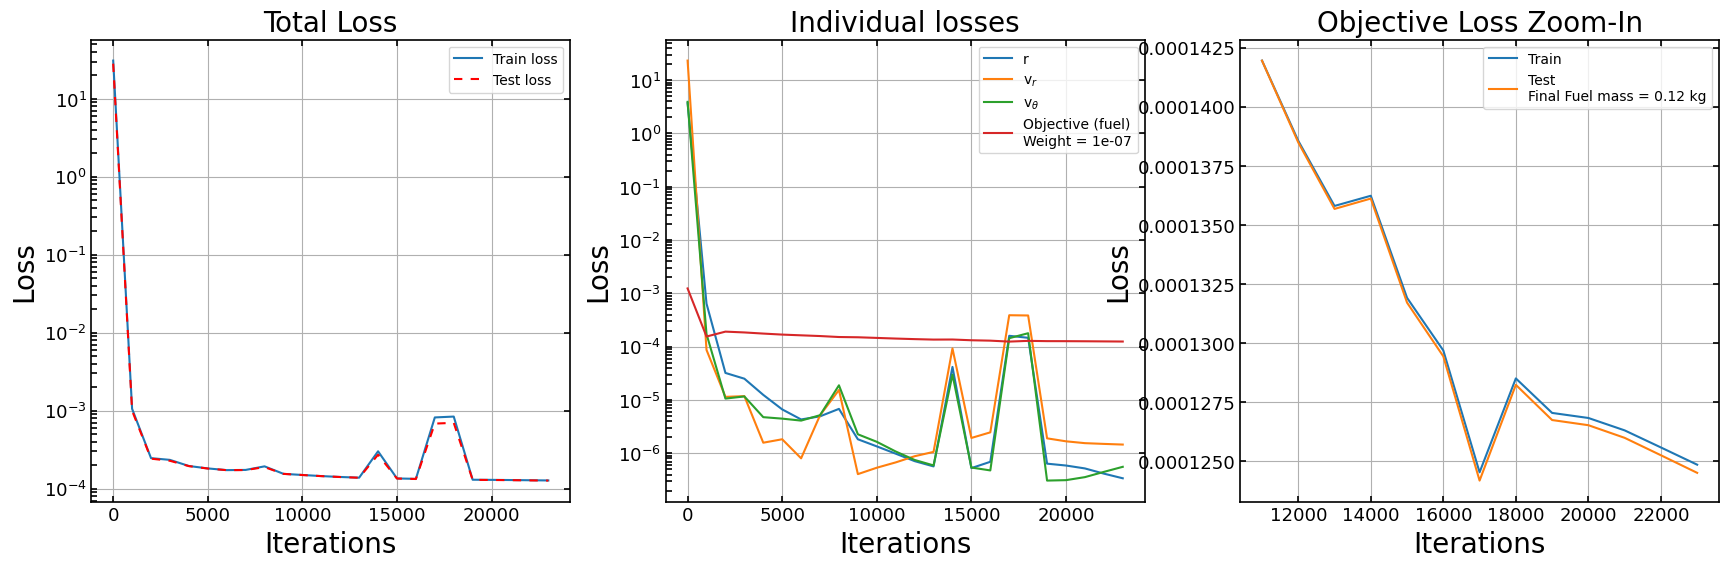

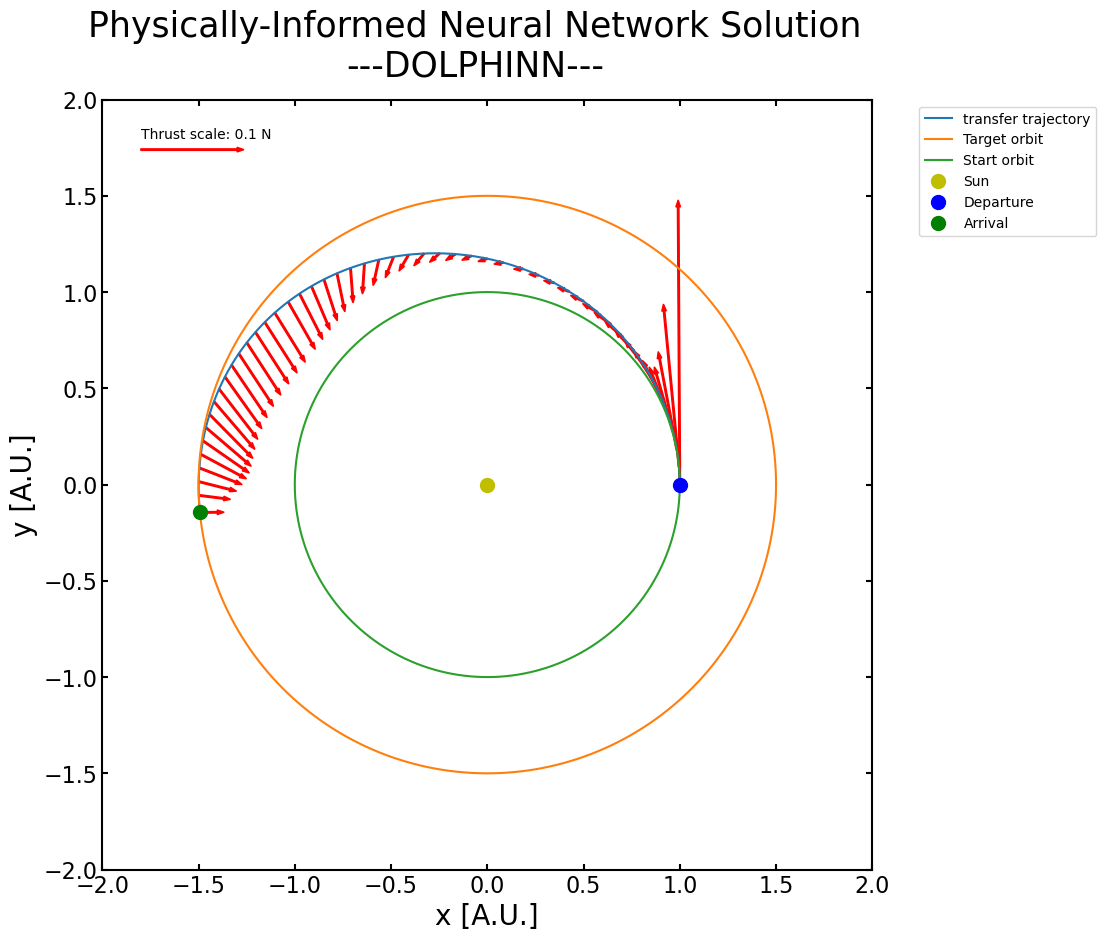

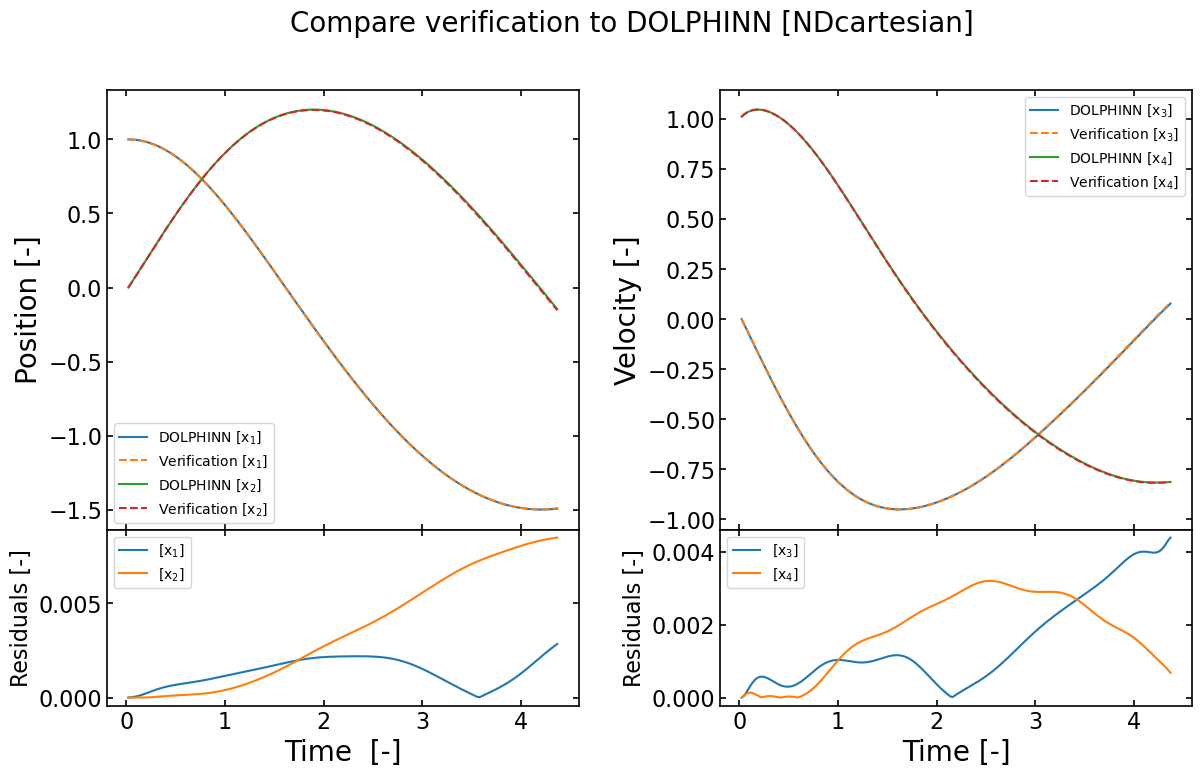

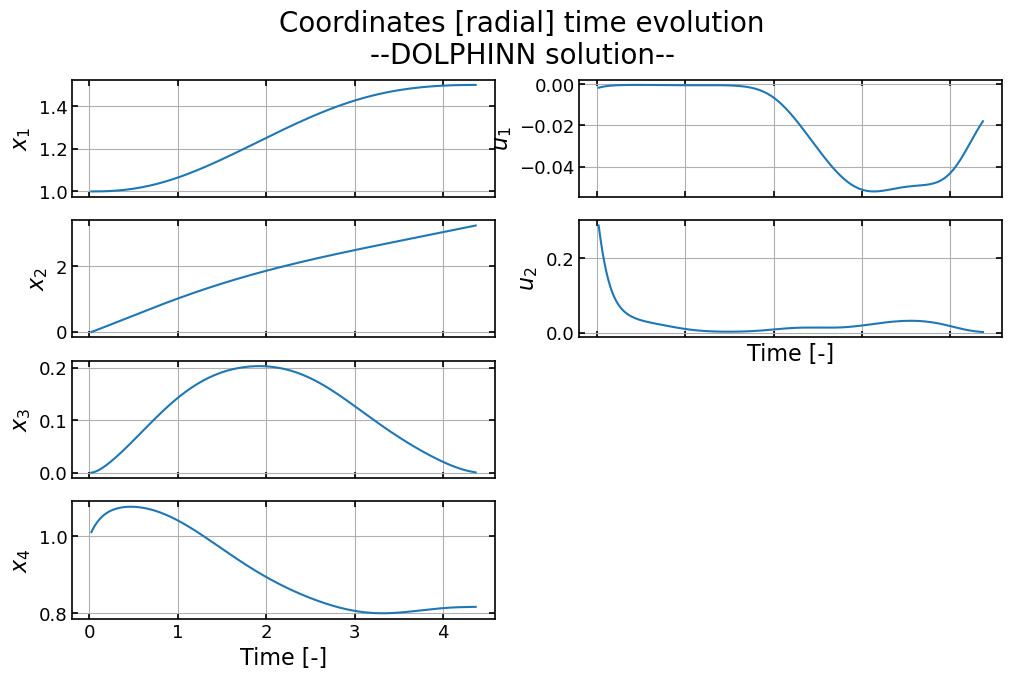

In [28]:
problem.verify()
plotting.plot_loss(problem, objective_zoom=True)  
plotting.plot_transfer(problem, thrust_scale = 0.1, r_target = 1.5, N_arrows = 50, lim = 2)
plotting.compare(problem, 'NDcartesian', log = False)
plotting.plot_coordinates(problem, "radial")

In [18]:
problem.store("../Data/test3/")

Folder exists


False